## Load Libraries and Create Function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
%matplotlib inline

In [2]:
class BinaryClassificationPerformance():
    '''Performance measures to evaluate the fit of a binary classification model'''
    
    def __init__(self, predictions, labels, desc, probabilities=None):
        '''Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y'''
        '''probabilities-optional, probability that Y is equal to True'''
        self.probabilities = probabilities
        self.performance_df = pd.concat([pd.DataFrame(predictions), pd.DataFrame(labels)], axis=1)
        self.performance_df.columns = ['preds', 'labls']
        self.desc = desc
        self.performance_measures = {}
  
    def compute_measures(self):
        '''Compute performance measures defined by Flach p. 57'''
        self.performance_measures['Pos'] = self.performance_df['preds'].sum()
        self.performance_measures['Neg'] = self.performance_df.shape[0] - self.performance_df['preds'].sum()
        self.performance_measures['TP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['TN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FP'] = ((self.performance_df['preds'] == True) & (self.performance_df['labls'] == False)).sum()
        self.performance_measures['FN'] = ((self.performance_df['preds'] == False) & (self.performance_df['labls'] == True)).sum()
        self.performance_measures['Accuracy'] = (self.performance_measures['TP'] + self.performance_measures['TN']) / (self.performance_measures['Pos'] + self.performance_measures['Neg'])

In [3]:
amazon = pd.read_csv('raw_data_test.csv', encoding ='latin-1')
print(amazon.shape)

(91000, 14)


In [4]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      288150        285340  285341  B005N29H36  A2YV9N5VCXSZLD   
1      255129         72523   72524  B003ZXAN4C  A2GA55P7WGHJCP   
2      385248         96069   96070  B004G5ZYN8  A1YHXGV6GC51IM   
3       12269          1209    1210  B005O072PC  A2BJTZ5JZHAJ9B   
4      173557        421393  421394  B001PBKZK8  A28QI87ZFODYC2   

                          ProfileName  HelpfulnessNumerator  \
0                          AlaskanKid                     0   
1                           domino113                     1   
2  Americangirl "TRUTH SETS YOU FREE"                     0   
3                Mona Osman "zolwica"                     9   
4                   I. Ramirez "suki"                     6   

   HelpfulnessDenominator  Score        Time  \
0                       0      5  1344297600   
1                       6      3  1295395200   
2                       0      2  1349568000   
3                      10 

## Feature Extraction from Natural Language Libraries

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
#from sklearn.feature_extraction.text import HashingVectorizer
#hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
#X_hv = hv.fit_transform(amazon.Text)
#print(X_hv.shape)

In [6]:
hv = joblib.load('hv.pkl') # pickle
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

(91000, 131072)


In [7]:
#from sklearn.feature_extraction.text import TfidfTransformer
#transformer = TfidfTransformer()
#X_tfidf = transformer.fit_transform(X_hv)

transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [8]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


## Creating Additional Features

In [9]:
import re
from string import punctuation

# length features
amazon['reviewLen'] = amazon['Text'].str.len()
amazon['profileLen'] = amazon['ProfileName'].str.len() 
amazon['summaryLen'] = amazon['Summary'].str.len() 

#count number of reviews made by the same reviewer
amazon['commCount'] = amazon.groupby('ProfileName')['ProfileName'].transform('count')

#Capital letter Features
amazon['profileCaps'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['summaryCaps'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))
amazon['reviewCaps'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(re.findall("[A-Z]", x)))

#punctuation features
amazon['profilePunc'] = amazon['ProfileName'][(np.isnan(amazon['profileLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['summaryPunc'] = amazon['Summary'][(np.isnan(amazon['summaryLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))
amazon['reviewPunc'] = amazon['Text'][(np.isnan(amazon['reviewLen'])) == 0].apply(lambda x: len(list(filter(lambda c: c in punctuation, x))))

#convert NaN's to 0
amazon['profileLen'][(np.isnan(amazon['profileLen']))] = 0
amazon['summaryLen'][(np.isnan(amazon['summaryLen']))] = 0
amazon['reviewLen'][(np.isnan(amazon['reviewLen']))] = 0
amazon['commCount'][(np.isnan(amazon['commCount']))] = 0
amazon['profileCaps'][(np.isnan(amazon['profileCaps']))] = 0
amazon['summaryCaps'][(np.isnan(amazon['summaryCaps']))] = 0
amazon['reviewCaps'][(np.isnan(amazon['reviewCaps']))] = 0
amazon['profilePunc'][(np.isnan(amazon['profilePunc']))] = 0
amazon['summaryPunc'][(np.isnan(amazon['summaryPunc']))] = 0
amazon['reviewPunc'][(np.isnan(amazon['reviewPunc']))] = 0

#Interactions
amazon['score_count'] = amazon['Score']*amazon['commCount']
amazon['len_count'] = amazon['reviewLen']*amazon['commCount']
amazon['score_len'] = amazon['Score']*amazon['reviewLen']

X_quant_features = amazon[['Score', 'reviewLen', 'Time', 'summaryLen', 'commCount', 'profileCaps', 'profileLen', 
                            'summaryCaps', 'reviewCaps', 'profilePunc', 'summaryPunc', 'reviewPunc', 'score_count', 'len_count', 'score_len']]
print(X_quant_features.head(10))
print(type(X_quant_features))

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying

   Score  reviewLen        Time  summaryLen  commCount  profileCaps  \
0      5        270  1344297600        23.0        2.0          2.0   
1      3        157  1295395200        27.0        1.0          0.0   
2      2        322  1349568000        36.0        5.0         17.0   
3      4        105  1149984000        12.0        3.0          2.0   
4      4        587  1335052800         5.0        1.0          2.0   
5      5        229  1349740800        26.0        1.0          1.0   
6      5        287  1274745600        24.0        1.0          3.0   
7      5        230  1305244800        23.0        2.0          4.0   
8      3       2093  1245196800         3.0        1.0          2.0   
9      5        503  1315612800        41.0        1.0          5.0   

   profileLen  summaryCaps  reviewCaps  profilePunc  summaryPunc  reviewPunc  \
0        10.0          1.0           4          0.0          4.0           4   
1         9.0          1.0           5          0.0       

C:\Users\Julian Bautista\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131087)


In [11]:
# feature scaling
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler(with_mean=False)
#X = sc.fit_transform(X_matrix)
#print(X.shape)

sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131087)


In [12]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


## Create Models

In [13]:
#from sklearn import linear_model
#svm = linear_model.SGDClassifier()
#svm.fit(X, y)
#joblib.dump(svm, 'svm.pkl') # pickle
svm = joblib.load('svm.pkl') # pickle

svm_performance = BinaryClassificationPerformance(svm.predict(X), y, 'svm')
svm_performance.compute_measures()
print(svm_performance.performance_measures)

{'FP': 4144, 'FN': 4922, 'Neg': 85127, 'TN': 80205, 'TP': 1729, 'Accuracy': 0.90037362637362639, 'Pos': 5873}


In [14]:
# MODEL: logistic regression
# from sklearn import linear_model
# lgs = linear_model.SGDClassifier(loss='log', n_iter=50, alpha=0.00001)
# lgs.fit(X, y)
# joblib.dump(lgs, 'lgs.pkl') # pickle
lgs = joblib.load('lgs.pkl')

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'FP': 4420, 'FN': 4779, 'Neg': 84708, 'TN': 79929, 'TP': 1872, 'Accuracy': 0.89891208791208788, 'Pos': 6292}


In [15]:
# MODEL: Naive Bayes
# from sklearn.naive_bayes import MultinomialNB
# nbs = MultinomialNB()
# nbs.fit(X, y)
# joblib.dump(nbs, 'nbs.pkl') # pickle
nbs = joblib.load('nbs.pkl')

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'FP': 12130, 'FN': 4041, 'Neg': 76260, 'TN': 72219, 'TP': 2610, 'Accuracy': 0.82229670329670335, 'Pos': 14740}


In [16]:
# MODEL: Ridge Regression Classifier
# from sklearn import linear_model
# rdg = linear_model.RidgeClassifier()
# rdg.fit(X, y)
# joblib.dump(rdg, 'rdg.pkl') # pickle
rdg = joblib.load('rdg.pkl')

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'FP': 1228, 'FN': 5697, 'Neg': 88818, 'TN': 83121, 'TP': 954, 'Accuracy': 0.92390109890109895, 'Pos': 2182}


In [17]:
# MODEL: Perceptron
# from sklearn import linear_model
# prc = linear_model.SGDClassifier(loss='perceptron')
# prc.fit(X, y)
# joblib.dump(prc, 'prc.pkl') # pickle
prc = joblib.load('prc.pkl')

prc_performance = BinaryClassificationPerformance(prc.predict(X), y, 'prc')
prc_performance.compute_measures()
print(prc_performance.performance_measures)

{'FP': 5865, 'FN': 4524, 'Neg': 83008, 'TN': 78484, 'TP': 2127, 'Accuracy': 0.88583516483516489, 'Pos': 7992}


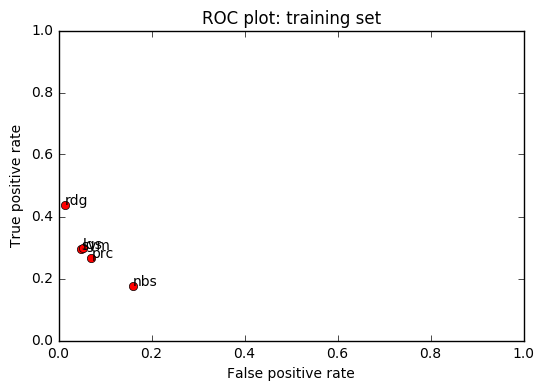

In [18]:
fits = [svm_performance, lgs_performance, nbs_performance, rdg_performance, prc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'ro')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()